In [1]:
import sys
import os
import re
import random
import keras
sys.path.append('../../../LIB/')
from utils import *
from customClasses.utils import *

np.random.seed(42)
pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

plt.rcParams['axes.facecolor'] = '#12162f'
plt.grid(False)
plt.close()

DATA_PATH = '../input/'
SPLIT_DATE = '2019-01-01'

Using TensorFlow backend.


[data overview](https://doc-0s-bg-docs.googleusercontent.com/docs/securesc/ehn0gf3bao47bmq1qaa15nqo4thqnecu/kb0opjk2seh3r2eb02a77m7j1fqklmff/1572861600000/06603566150954428909/05576845911769771244/1QdxvAXep1_kJX_CzpGnwkGz3qE6_pgkc?h=08654040859286330787)

In [12]:
# Read CSV casitng dates
DATA_PATH = './data'
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'))
answer_scores = pd.read_csv(os.path.join(DATA_PATH, 'answer_scores.csv'))
comments = pd.read_csv(os.path.join(DATA_PATH, 'comments.csv'))
emails = pd.read_csv(os.path.join(DATA_PATH, 'emails.csv'))
groups = pd.read_csv(os.path.join(DATA_PATH, 'groups.csv'))
group_memberships = pd.read_csv(os.path.join(DATA_PATH, 'group_memberships.csv'))
matches = pd.read_csv(os.path.join(DATA_PATH, 'matches.csv'))
professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'))
questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'))
question_scores = pd.read_csv(os.path.join(DATA_PATH, 'question_scores.csv')) 
school_memberships = pd.read_csv(os.path.join(DATA_PATH, 'school_memberships.csv'))
students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'))
tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tag_questions = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv'))
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv'))

In [13]:
# Datetimes features preprocessing
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

## Activity features

In [14]:
# Last Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last Activity
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First Activity
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)

In [15]:
tp = TextProcessor()
# processing text for answers entity
answers['answers_body'] = answers['answers_body'].astype(str)
answers = tp.transform(answers,column='answers_body')
ans_train = answers[answers['answers_date_added'] < SPLIT_DATE]

# processing text for questions entity
questions = tp.transform(questions,column='questions_title')
questions = tp.transform(questions,column='questions_body')
questions['questions_whole'] = questions['questions_title'] + ' ' + questions['questions_body']
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]


# processing text for professionals entity
professionals['professionals_headline'] = professionals['professionals_headline'].astype(str)
professionals['professionals_industry'] = professionals['professionals_industry'].astype(str)

professionals = tp.transform(professionals,column='professionals_headline')
professionals = tp.transform(professionals,column='professionals_industry')
pro_train = professionals[professionals['professionals_date_joined'] < SPLIT_DATE]

stu_train = students[students['students_date_joined'] < SPLIT_DATE]
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]


tags['tags_tag_name'] = tags['tags_tag_name'].astype(str)
tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = tag_users.merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_d2v(df: pd.DataFrame, target: str, features: list, dim: int) -> (Doc2Vec, dict):
    """
    Train Doc2Vec object on provided data
    :param df: data to work with
    :param target: column name of target entity in df to train embeddings for
    :param features: list of feature names to be used for training
    :param dim: dimension of embedding vectors to train
    :return: trained Doc2Vec object
    """
    prepared = []
    for feature in features:
        if feature != target:
            prepared += [TaggedDocument(row[feature].split(), [row[target]])
                         for i, row in df[[feature, target]].drop_duplicates().iterrows()]
        else:
            prepared += [TaggedDocument(s.split(), [s]) for s in df[target].drop_duplicates()]
    # shuffle prepared data, just in case
    prepared = random.sample(prepared, len(prepared))
    d2v = Doc2Vec(prepared, vector_size=dim, workers=4, epochs=10, dm=0)
    docvecs = {d2v.docvecs.index2entity[i]: d2v.docvecs.vectors_docs[i]
               for i in range(len(d2v.docvecs.index2entity))}
    return d2v, docvecs


def pipeline_d2v(que: pd.DataFrame, ans: pd.DataFrame, pro: pd.DataFrame, tag_que: pd.DataFrame, tag_pro: pd.DataFrame,
                 dim: int) -> (dict, dict, Doc2Vec):
    """
    Pipeline for training embeddings for
    professional's industries and question's tags via doc2vec algorithm
    on question titles, bodies, answer bodies, names of tags, professional industries and headlines

    :param que: raw questions.csv dataset
    :param ans: raw answers.csv dataset
    :param pro: raw professionals.csv dataset
    :param tag_que: tags.csv merged with tag_questions.csv
    :param tag_pro: tags.csv merged with tag_users.csv
    :param dim: dimension of doc2vec embeddings to train
    :return: trained tags, industries embeddings and question's Doc2Vec model
    """
    # aggregate all the tags in one string for same professionals
    pro_tags = tag_pro[['tag_users_user_id', 'tags_tag_name']].groupby(by='tag_users_user_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x)).rename(columns={'tags_tag_name': 'tags_pro_name'})
    pro_tags = pro.merge(pro_tags, left_on='professionals_id', right_on='tag_users_user_id')

    # merge questions, tags, answers and professionals
    que_tags = que.merge(tag_que, left_on='questions_id', right_on='tag_questions_question_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    text_features = ['questions_title', 'questions_body', 'answers_body', 'tags_tag_name', 'tags_pro_name',
                     'professionals_industry', 'professionals_headline']

    # train and save question's tags embeddings
    _, tags_embs = train_d2v(df, 'tags_tag_name', text_features, dim)

    # aggregate all the tags in one string for same questions
    que_tags = que_tags[['questions_id', 'tags_tag_name']].groupby(by='questions_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x))

    # merge questions, aggregated tags, answers and professionals
    que_tags = que.merge(que_tags, on='questions_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    # train and save professional's industries embeddings
    _, inds_embs = train_d2v(df, 'professionals_industry', text_features, dim)

    head_d2v, _ = train_d2v(df, 'professionals_headline', text_features, 5)

    ques_d2v, _ = train_d2v(que_tags, 'questions_id', ['questions_whole'], dim)

    return tags_embs, inds_embs, head_d2v, ques_d2v

In [17]:
n_emb = 10
#trained tags, industries embeddings and question's Doc2Vec model
tag_embs, ind_embs, head_d2v, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, tag_pro, n_emb)

In [33]:
from sklearn.manifold import TSNE

def vis_emb(id_to_vec: dict, occurrences: pd.Series, title: str):
    """
    Visualize embeddings via T-SNE
    """
    top = set(occurrences.value_counts().iloc[:100].index)
    filtered = {key: value for key, value in id_to_vec.items() if key in top}
    
    proj = TSNE(n_components=2).fit_transform(np.vstack(filtered.values()))
    
    _, ax = plt.subplots(figsize=(12, 12))
    plt.scatter(proj[:, 0], proj[:, 1], alpha=0.7, s=90, c='#69f0ff')
    for i, name in enumerate(filtered.keys()):
        ax.annotate(name, (proj[i, 0], proj[i, 1]), color='w')
        
    ax.set_title(title, fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.show()

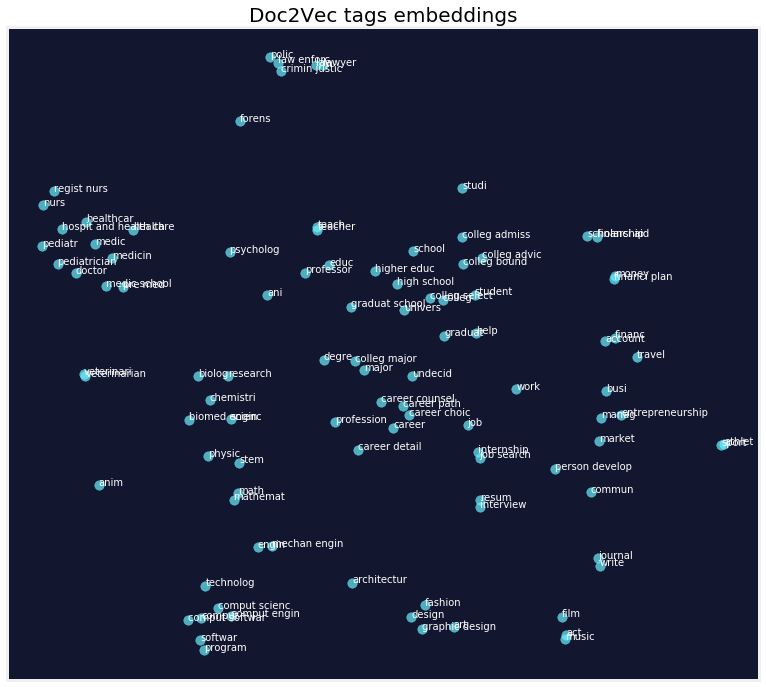

In [34]:
vis_emb(tag_embs, tag_que['tags_tag_name'], 'Doc2Vec tags embeddings')

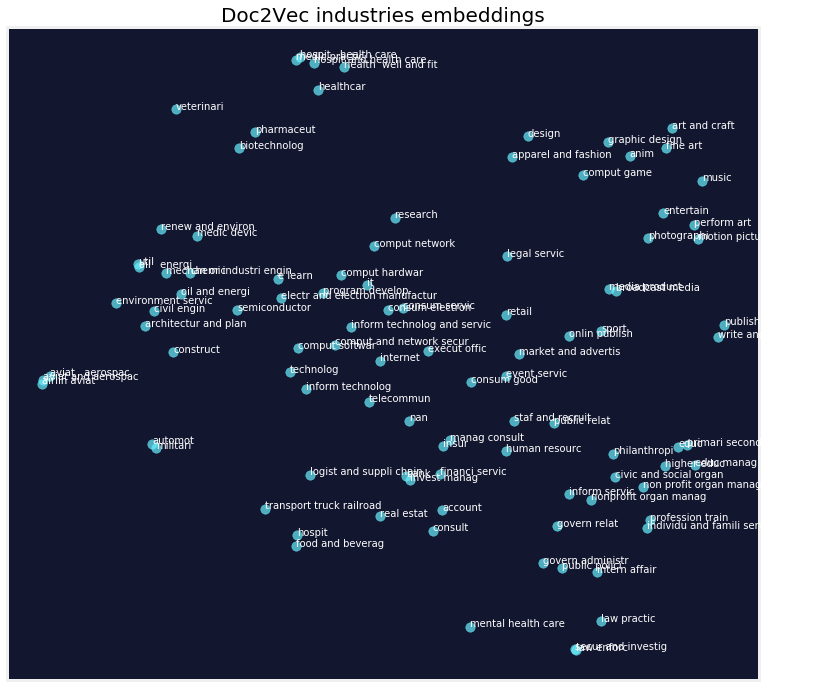

In [35]:
vis_emb(ind_embs, pro_train['professionals_industry'], 'Doc2Vec industries embeddings')

In [143]:
# construct dataframe used to extract positive pairs
pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# extract professional answers for activity filters
pro_answers = pairs_df.drop(columns=['students_id']).set_index('professionals_id')

In [144]:
pairs_df.head()

,questions_id,students_id,professionals_id,answers_date_added
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14
1,7a0d4bc67b1c492fb06fe455b1c07faf,8f6f374ffd834d258ab69d376dd998f5,05ab77d4c6a141b999044ebbf5415b0d,2018-03-08 18:23:36
2,7a0d4bc67b1c492fb06fe455b1c07faf,8f6f374ffd834d258ab69d376dd998f5,05ab77d4c6a141b999044ebbf5415b0d,2018-03-08 18:24:03
3,7a0d4bc67b1c492fb06fe455b1c07faf,8f6f374ffd834d258ab69d376dd998f5,58fa5e95fe9e480a9349bbb1d7faaddb,2016-07-03 18:38:36
4,0f1d6a4f276c4a05878dd48e03e52289,585ac233015447cc9e9a217044e515e1,36ff3b3666df400f956f8335cf53e09e,2016-07-31 15:35:54


In [145]:
qa_data = questions.merge(answers, left_on='questions_id', right_on='answers_question_id')
qa_data.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_whole,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,teacher career question,what is a math teacher what is a mat...,teacher career question what is a math ...,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14,hi you are ask a veri interest question ...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,i want to becom an armi offic what can i do t...,i am priyanka from bangalor now am in th s...,i want to becom an armi offic what can i do t...,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08,hi i join the armi after i attend colleg and...
2,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,i want to becom an armi offic what can i do t...,i am priyanka from bangalor now am in th s...,i want to becom an armi offic what can i do t...,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02,dear priyanka greet i have answer thi ques...
3,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,will go abroad for your first job increas your...,i m plan on go abroad for my first job it wil...,will go abroad for your first job increas your...,1a6b3749d391486c9e371fbd1e605014,7e72a630c303442ba92ff00e8ea451df,4ec31632938a40b98909416bdd0decff,2017-05-10 19:00:47,i work for a global compani who valu highli i...
4,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,to becom a specialist in busi manag will i h...,i hear busi manag is a hard way to get a job i...,to becom a specialist in busi manag will i h...,5229c514000446d582050f89ebd4e184,17802d94699140b0a0d2995f30c034c6,2f6a9a99d9b24e5baa50d40d0ba50a75,2017-10-13 22:07:33,i agre with denis everi singl job i ve had si...


In [23]:
que_train.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_whole
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,teacher career question,what is a math teacher what is a mat...,teacher career question what is a math ...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,i want to becom an armi offic what can i do t...,i am priyanka from bangalor now am in th s...,i want to becom an armi offic what can i do t...
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,will go abroad for your first job increas your...,i m plan on go abroad for my first job it wil...,will go abroad for your first job increas your...
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,to becom a specialist in busi manag will i h...,i hear busi manag is a hard way to get a job i...,to becom a specialist in busi manag will i h...
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,are there ani scholarship out there for studen...,i m tri to find scholarship for first year stu...,are there ani scholarship out there for studen...


In [29]:
tags.head()

,tags_tag_id,tags_tag_name
0,27490,colleg
1,461,comput scienc
2,593,comput softwar
3,27292,busi
4,18217,doctor


In [28]:
tag_questions.head()

,tag_questions_tag_id,tag_questions_question_id
0,28930,cb43ebee01364c68ac61d347a393ae39
1,28930,47f55e85ce944242a5a347ab85a8ffb4
2,28930,ccc30a033a0f4dfdb2eb987012f25792
3,28930,e30b274e48d741f7bf50eb5e7171a3c0
4,28930,3d22742052df4989b311b4195cbb0f1a


In [ ]:
"""
#### Question's features processing class
- **Numerical**
    - Question's body length in symbols
    - Question's number of tags
- Averaged question's tags embeddings pre-trained via doc2vec
- Unique question's embedding inferred via doc2vec 
"""

class process_quest_features:
    """
    :que: question dataFrame with preprocessed dataset
    :tags: merged tags and tag_questions dataframes with preprocessed textual columns
    :return: dataframe of question's id, question's date added and model-friendly question's features
    """
    
    def __init__(self):
        pass
    
    def transform(self, que, tags):
        que['questions_body_len'] = ques['questions_body'].apply(lambda x:len(str(x)))
        # append aggregated tags to each question
        tags_grouped = tags.groupby('tag_questions_question_id', as_index=False)[['tags_tag_name']] \
            .agg(lambda x: ' '.join(set(x)))
        tags_grouped['questions_tag_count'] = tags_grouped['tags_tag_name'].apply(lambda x: len(x.split()))
        df = que.merge(tags_grouped, how='left', left_on='questions_id', right_on='tag_questions_question_id')
        
        # prepare tag embeddings

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_embs = df['tags_tag_name'].apply(__convert)

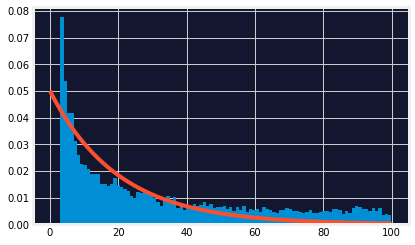

In [129]:
qa_data['duration_to_answer'] =  pd.to_datetime(qa_data['answers_date_added']) - pd.to_datetime(qa_data['questions_date_added'])
# qa_data['duration_to_answer'].dt.seconds.plot(kind='hist', figsize=(15,10), bins=200, density=True)
que_age = qa_data['duration_to_answer'].apply(lambda x: x.days + np.round(x.seconds / 3600) / 24)
cut_que_age = que_age[(que_age < 100) & (que_age > 3)]
cut_que_age.hist(bins=100, density=True)

lambd = 1 / 20

# Plot exponential distribution
x = np.linspace(0, 100, 1000)
y = lambd * np.exp(-lambd * x)

plt.plot(x, y)
plt.show()

In [5]:
class BatchGenerator(keras.utils.Sequence):
    """
    Class to ingest data from pre-processed DataFrames to model
    in form of batches of NumPy arrays
    """
    
    exp_mean = 30
    
    def __init__(self, que: pd.DataFrame, stu: pd.DataFrame, pro: pd.DataFrame,
                 batch_size: int, pos_pairs: list, nonneg_pairs: list, pro_dates: dict):
        """
        :param que: pre-processed questions data
        :param stu: pre-processed students data
        :param pro: pre-processed professionals data
        :param batch_size: actually, half of the real batch size
        Number of both positive and negative pairs present in generated batch
        :param pos_pairs: tuples of question, student and professional, which form positive pair
        (professional answered on the given question from corresponding student)
        :param nonneg_pairs: tuples of question, student and professional, which are known to form a positive pair.
        Superset of pos_pairs, used in sampling of negative pairs
        :param pro_dates: mappings from professional's id to his registration date
        """
        self.batch_size = batch_size

        # extract mappings from question's id to question's date and features
        que_ar = que.values
        self.que_feat = {que_ar[i, 0]: que_ar[i, 2:] for i in range(que_ar.shape[0])}
        self.que_time = {que_ar[i, 0]: pd.Timestamp(que_ar[i, 1]) for i in range(que_ar.shape[0])}

        self.pos_pairs = pos_pairs
        self.on_epoch_end()  # shuffle pos_pairs
        self.nonneg_pairs = {(que, stu, pro) for que, stu, pro, time in nonneg_pairs}

        # these lists are used in sampling of negative pairs
        self.ques_stus_times = [(que, stu, self.que_time[que]) for que, stu, pro, time in pos_pairs]

        self.pros = np.array([pro for que, stu, pro, time in nonneg_pairs])
        self.pros_times = np.array([pro_dates[pro] for que, stu, pro, time in nonneg_pairs])

        # simultaneously sort two arrays containing professional features
        sorted_args = np.argsort(self.pros_times)
        self.pros = self.pros[sorted_args]
        self.pros_times = self.pros_times[sorted_args]

        # extract mappings from student's id to student's date and features
        self.stu_feat = {}
        self.stu_time = {}
        for stu_id, group in stu.groupby('students_id'):
            group_ar = group.values[:, 1:]
            self.stu_feat[stu_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.stu_time[stu_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

        # extract mappings from professional's id to professional's date and features
        self.pro_feat = {}
        self.pro_time = {}
        for pro_id, group in pro.groupby('professionals_id'):
            group_ar = group.values[:, 1:]
            self.pro_feat[pro_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.pro_time[pro_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

    def __len__(self):
        return len(self.pos_pairs) // self.batch_size

    @staticmethod
    def __find(feat_ar: np.ndarray, time_ar: np.ndarray, search_time):
        pos = np.searchsorted(time_ar[1:], search_time)
        assert time_ar[pos] is pd.NaT or time_ar[pos] < search_time
        return feat_ar[pos]

    def __convert(self, pairs: list) -> (np.ndarray, np.ndarray):
        """
        Convert list of pairs of ids to NumPy arrays
        of question and professionals features
        """
        x_que, x_pro, current_times = [], [], []
        for que, stu, pro, current_time in pairs:
            que_data = self.que_feat[que]

            # find student's and professional's feature at current time
            stu_data = BatchGenerator.__find(self.stu_feat[stu], self.stu_time[stu], current_time)
            pro_data = BatchGenerator.__find(self.pro_feat[pro], self.pro_time[pro], current_time)

            # prepare current time as feature itself
            current_time = current_time.year + (current_time.dayofyear + current_time.hour / 24) / 365
            current_times.append(current_time)

            x_que.append(np.hstack([stu_data, que_data]))
            x_pro.append(pro_data)

        # and append them to both questions and professionals
        return np.vstack(x_que), np.vstack(x_pro)

    def __getitem__(self, index):
        """
        Generate the batch
        """
        pos_pairs = self.pos_pairs[self.batch_size * index: self.batch_size * (index + 1)]
        neg_pairs = []

        for i in range(len(pos_pairs)):
            while True:
                # sample question, its student and time
                que, stu, zero = random.choice(self.ques_stus_times)
                # calculate shift between question's and current time
                shift = np.random.exponential(BatchGenerator.exp_mean)
                current_time = zero + pd.Timedelta(int(shift * 24 * 60), 'm')
                # find number of professionals with registration date before current time
                i = np.searchsorted(self.pros_times, current_time)
                if i != 0:
                    break

            while True:
                # sample professional for negative pair
                pro = random.choice(self.pros[:i])
                # check if he doesn't form a positive pair
                if (que, stu, pro) not in self.nonneg_pairs:
                    neg_pairs.append((que, stu, pro, current_time))
                    break

        # convert lists of pairs to NumPy arrays of features
        x_pos_que, x_pos_pro = self.__convert(pos_pairs)
        x_neg_que, x_neg_pro = self.__convert(neg_pairs)

        # return the data in its final form
        return [np.vstack([x_pos_que, x_neg_que]), np.vstack([x_pos_pro, x_neg_pro])], \
               np.vstack([np.ones((len(x_pos_que), 1)), np.zeros((len(x_neg_que), 1))])

    def on_epoch_end(self):
        # shuffle positive pairs
        self.pos_pairs = random.sample(self.pos_pairs, len(self.pos_pairs))
# mappings from professional's id to his registration date. Used in batch generator
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in professionals.iterrows()}

In [6]:
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

NameError: name 'que_data' is not defined